# Image to image with Azure Computer Vision and Azure Open AI for Dall e 2

We are going to use Bing Image search to get an image from Bing using a prompt. 
Then we are going to use **Azure Computer Vision 4 Florence** to get the main caption and the tags from the Bing image.
Then we will use this caption as a prompt to generate an artificial image using **Azure Open AI and its Dall e 2** integration.

In [1]:
import datetime
import glob
import openai
import os
import requests
import sys
import time

from dotenv import load_dotenv
from io import BytesIO
from IPython.display import Image as viewimage
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [3]:
print("Today:", datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"))

Today: 05-Sep-2023 14:35:41


In [4]:
IMAGES_DIR = "bing_images"
RESULTS_DIR = "artificial_images"

os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

## You need to specify your credentials in the azure.env file

In [5]:
!ls azure.env -lh

-rwxrwxrwx 1 root root 434 Sep  5 14:11 azure.env


## Functions

In [6]:
def image_bing_search(search_term, idx=0):
    """
    Get image from Bing Search
    """
    # Get key and endpoint for the Bing Search service
    load_dotenv("azure.env")
    bing_key = os.getenv("bing_key")
    bing_search_url = os.getenv("bing_search_url")

    # Settings
    headers = {"Ocp-Apim-Subscription-Key": bing_key}
    params = {"q": search_term, "license": "public", "imageType": "photo"}

    # Running the bing search service
    response = requests.get(bing_search_url, headers=headers, params=params)

    response.raise_for_status()
    search_results = response.json()

    # Getting the image
    thumbnail_url = search_results["value"][idx]["thumbnailUrl"]
    image = requests.get(thumbnail_url)
    image.raise_for_status()
    img = Image.open(BytesIO(image.content))

    # Saving the image
    output_file = os.path.join(IMAGES_DIR, search_term + ".jpg")
    img.save(output_file)

    return img, output_file

In [7]:
def get_caption(image_file):
    """
    Get caption from an image using Azure Computer Vision 4
    """
    # Get key and endpoint for Azure Computer Vision service
    load_dotenv("azure.env")
    key = os.getenv("azure_cv_key")
    endpoint = os.getenv("azure_cv_endpoint")

    # settings
    options = "&features=caption,tags"
    model = "?api-version=2023-02-01-preview&modelVersion=latest"
    url = endpoint + "/computervision/imageanalysis:analyze" + model + options
    headers = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": key,
    }

    # Read the image file
    with open(image_file, "rb") as f:
        data = f.read()

    # Sending the requests
    response = requests.post(url, data=data, headers=headers)
    results = response.json()

    # Parsing the results
    image_caption = results["captionResult"]["text"]
    tags = results["tagsResult"]["values"]
    tags_string = ", ".join(item["name"] for item in tags)
    caption = image_caption + ", " + tags_string

    return caption

In [8]:
def dalle2(prompt, size=1024):
    """
    Generate an image from a prompt with Dall e 2
    """
    # prompt
    extra_prompt = "full view, detailled, 8K"
    image_prompt = prompt + extra_prompt

    # Get the endpoint and key for Azure Open AI
    load_dotenv("azure.env")
    openai.api_base = os.getenv("azure_openai_endpoint")
    openai.api_key = os.getenv("azure_openai_key")

    api_version = "2023-06-01-preview"
    url = (
        f"{openai.api_base}/openai/images/generations:submit?api-version={api_version}"
    )
    headers = {
        "api-key": openai.api_key,
        "Content-Type": "application/json",
    }

    if size == 512:
        imagesize = "512x512"
    elif size == 1024:
        imagesize = "1024x1024"
    elif size == 256:
        imagesize = "256x256"
    else:
        imagesize = "1024x1024"

    body = {"prompt": image_prompt, "size": imagesize, "n": 1}

    submission = requests.post(url, headers=headers, json=body)
    operation_location = submission.headers["operation-location"]
    status = ""

    while status != "succeeded":
        time.sleep(1)
        response = requests.get(operation_location, headers=headers)
        status = response.json()["status"]

    # Get the first generated image
    image_url = response.json()["result"]["data"][0]["url"]
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Saving the artificial image
    output_file = os.path.join(RESULTS_DIR, "dalle2_" + search_term + ".jpg")
    img.save(output_file)

    return img, output_file

In [9]:
def display_images(imagefile1, imagefile2):
    """
    Display two images side by side
    """
    # Reading images
    img1 = plt.imread(imagefile1)
    img2 = plt.imread(imagefile2)

    # Subplots
    f, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].imshow(img1)
    ax[1].imshow(img2)

    # Titles
    ax[0].set_title("Bing Search image")
    ax[1].set_title("DALL·E 2 artificial image")
    title = "Image to image with Bing Search, Azure Computer Vision and Azure Open AI"
    f.suptitle(title, fontsize=15)
    plt.tight_layout()

    # Removing the axis
    ax[0].axis("off")
    ax[1].axis("off")

    plt.show()

## Testing

## Test 1

In [10]:
search_term = "a red motorcycle in a street"

bing_images/a red motorcycle in a street.jpg


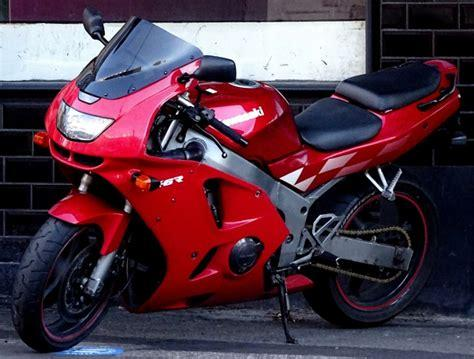

In [11]:
img, image_file = image_bing_search(search_term, idx=1)

print(image_file)
viewimage(filename=image_file, width=512)

In [12]:
prompt = get_caption(image_file)
prompt

'a red motorcycle parked on the pavement, motorcycle, vehicle, land vehicle, tire, wheel, motorbike, outdoor, auto part, red, brake, motorcycle fairing, fuel tank, vehicle brake, scooter, automotive exhaust, parked, muffler, fender, moped, rim, disc brake, exhaust system, road, automotive lighting, bike, ground, street'

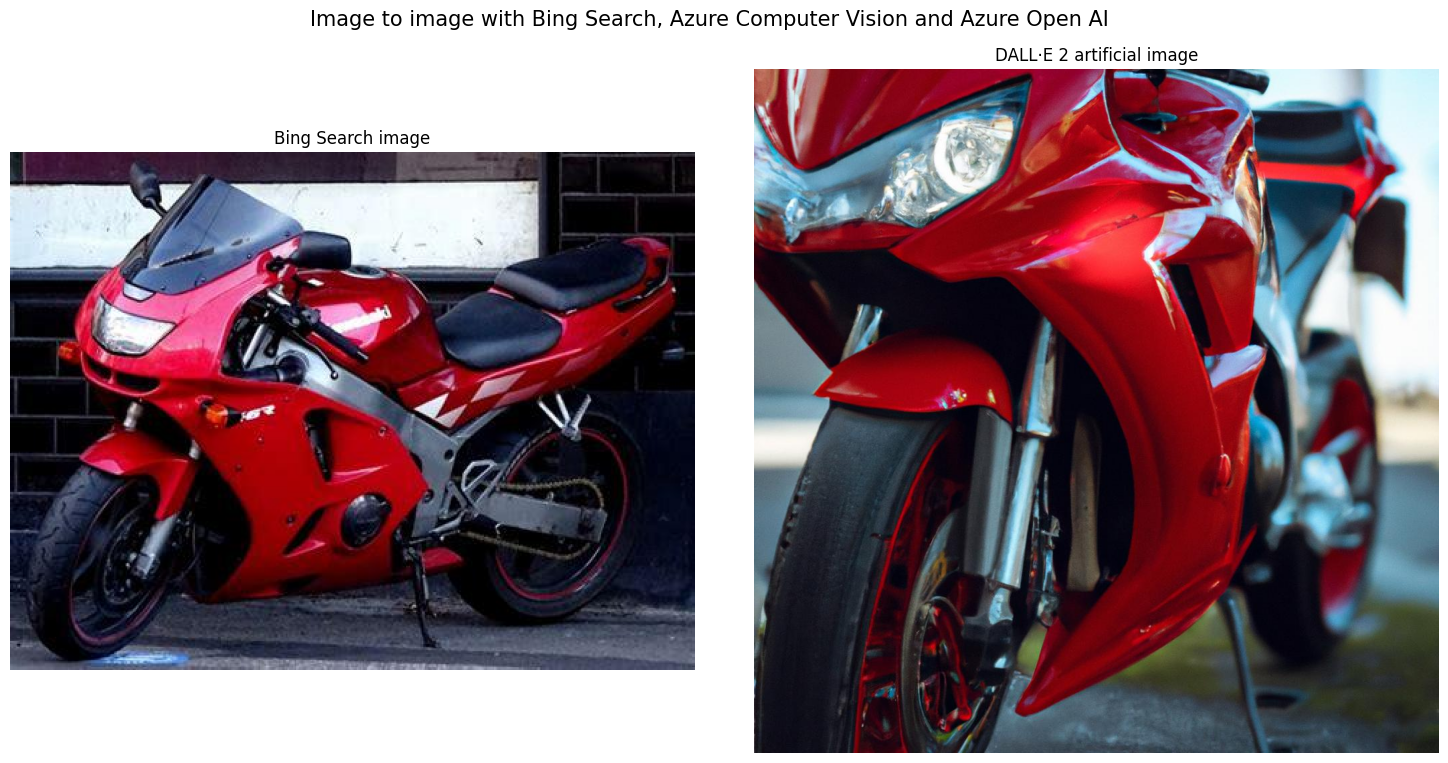

In [13]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)

## Test 2

In [14]:
search_term = "a tropical island"

bing_images/a tropical island.jpg


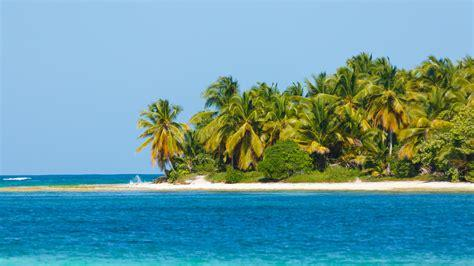

In [15]:
img, image_file = image_bing_search(search_term, idx=1)

print(image_file)
viewimage(filename=image_file, width=512)

In [16]:
prompt = get_caption(image_file)
prompt

'a tropical island with palm trees, outdoor, tropics, nature, caribbean, water, tree, palm tree, coastal and oceanic landforms, beach, arecales, aqua, sky, island, coast, shore, cay, body of water, azure, attalea speciosa, sea, vacation, ocean, landscape'

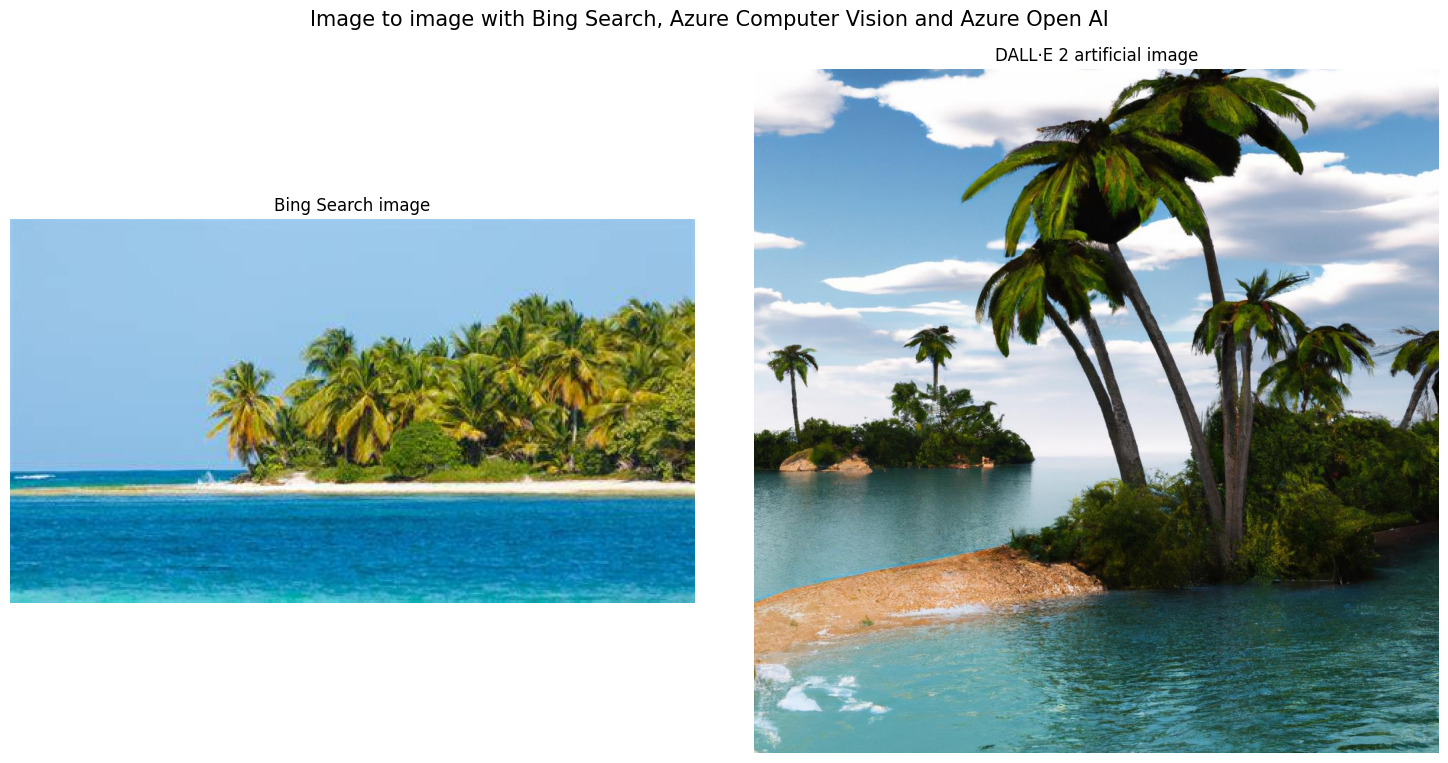

In [17]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)

## Test 3

In [18]:
search_term = "beautiful garden"

bing_images/beautiful garden.jpg


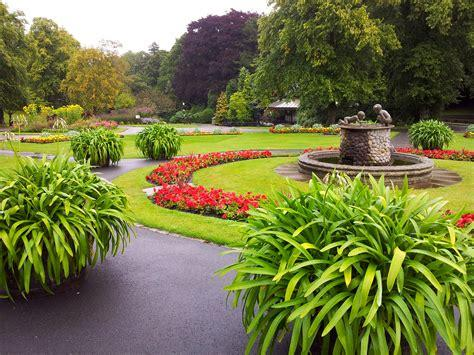

In [19]:
img, image_file = image_bing_search(search_term, idx=1)

print(image_file)
viewimage(filename=image_file, width=512)

In [20]:
prompt = get_caption(image_file)
prompt

'a park with a fountain and flowers, tree, outdoor, landscaping, botanical garden, grass, hedge, shrub, sky, plant, yard, fountain, garden, flower, park'

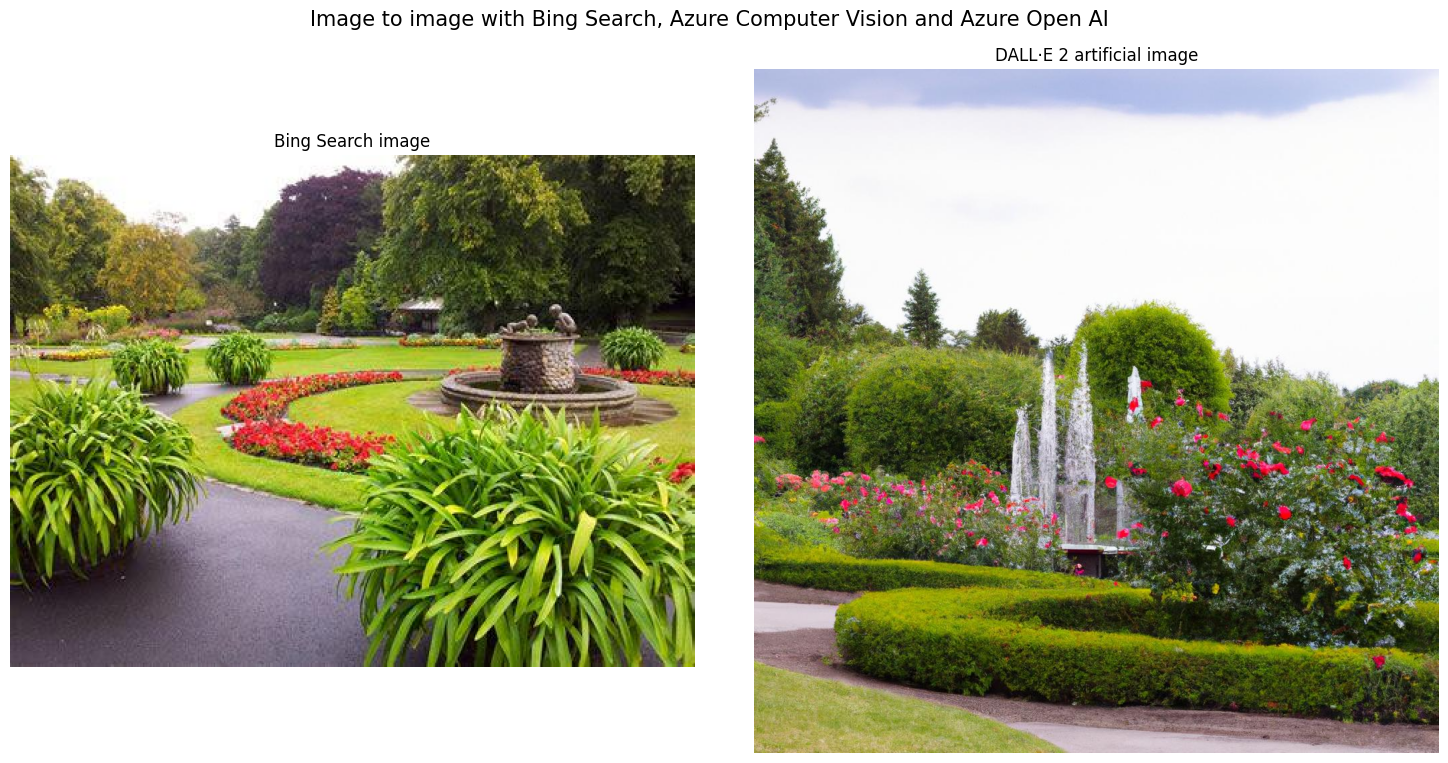

In [21]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)

## Test 4

In [22]:
search_term = "an aerial view of a snowy mountain"

bing_images/an aerial view of a snowy mountain.jpg


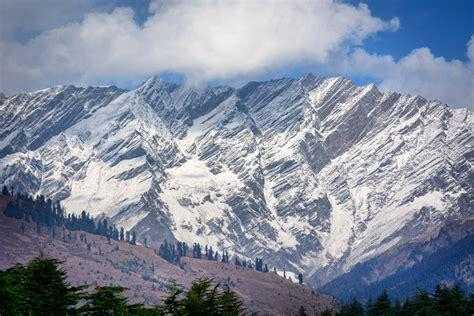

In [23]:
img, image_file = image_bing_search(search_term, idx=0)

print(image_file)
viewimage(filename=image_file, width=512)

In [24]:
prompt = get_caption(image_file)
prompt

'a snowy mountain with trees, outdoor, nature, cloud, sky, mountain range, mountain, landscape, massif, tree, alps, summit, ridge, snow, araate, highland, glacial landform, moraine, terrain, hill station, wilderness, valley'

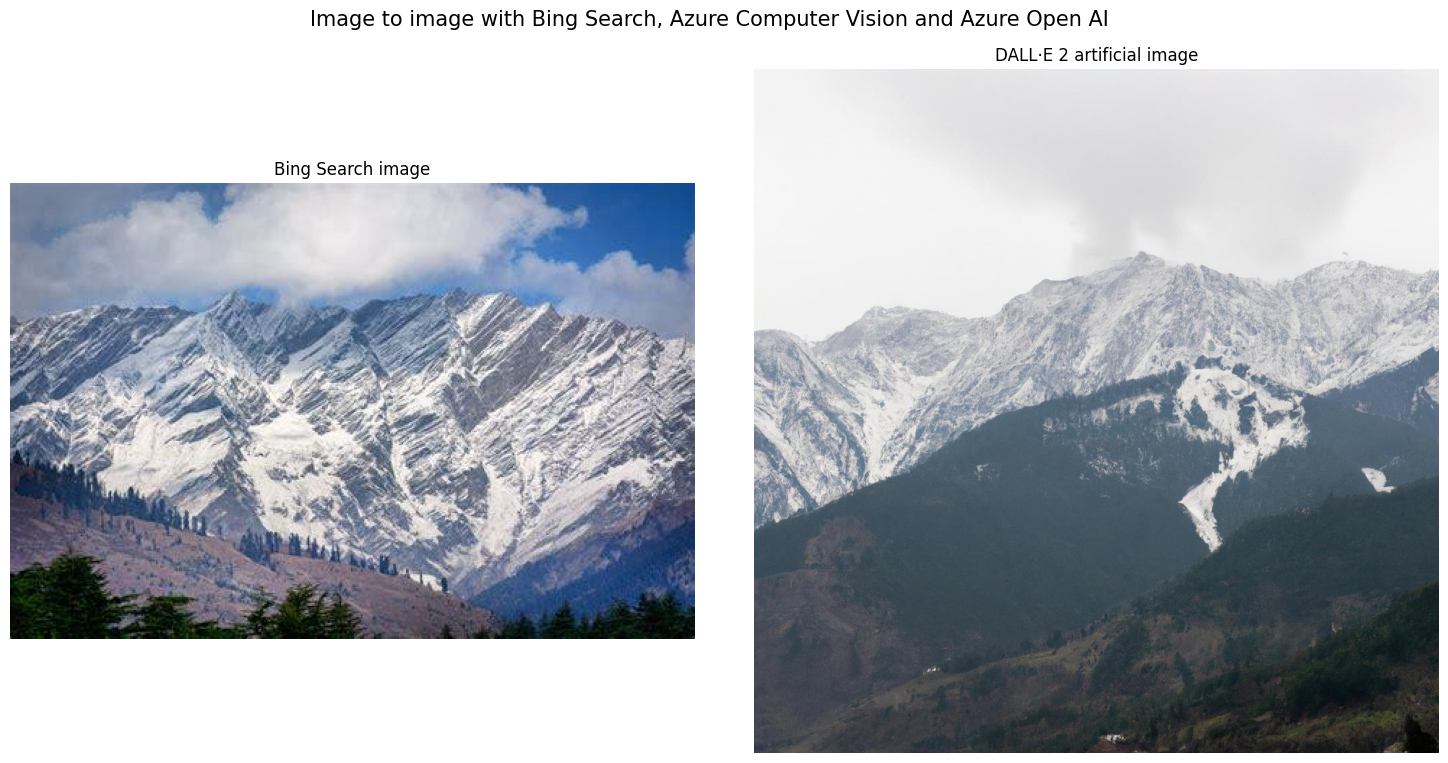

In [25]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)

## Test 5

In [26]:
search_term = "orchids"

bing_images/orchids.jpg


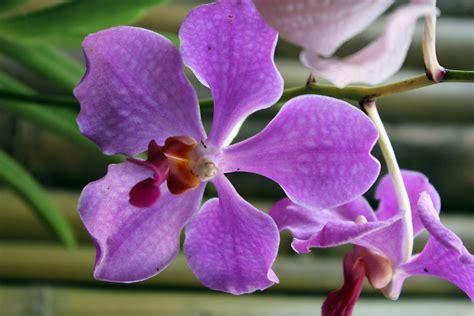

In [27]:
img, image_file = image_bing_search(search_term, idx=0)

print(image_file)
viewimage(filename=image_file, width=512)

In [28]:
prompt = get_caption(image_file)
prompt

'a close up of a purple flower, plant, flower, orchid, petal, orchids of the philippines, phalaenopsis equestris, moth orchid, purple'

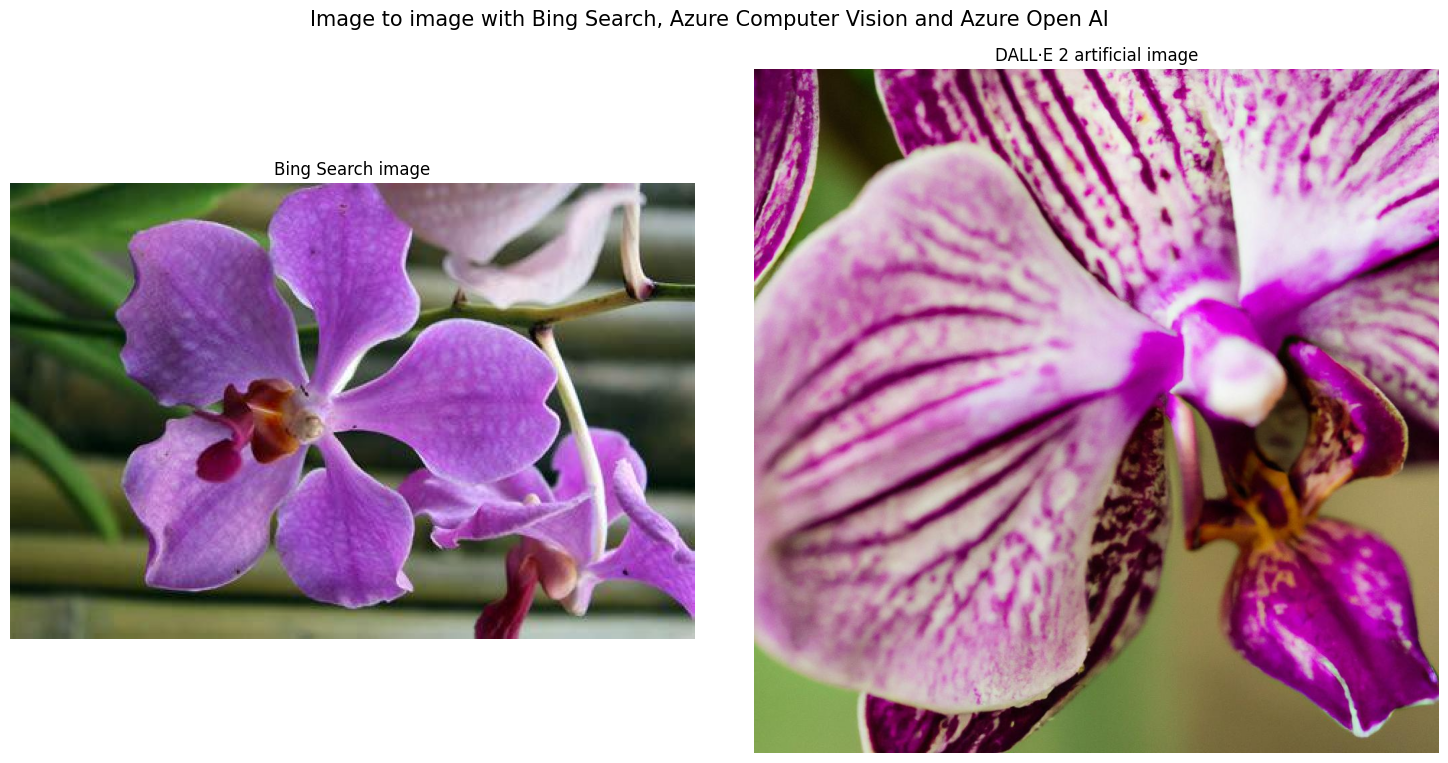

In [29]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)

In [30]:
[file for file in glob.glob(IMAGES_DIR + "/*.*") if file.endswith(("jpg"))]

['bing_images/a red motorcycle in a street.jpg',
 'bing_images/a tropical island.jpg',
 'bing_images/an aerial view of a snowy mountain.jpg',
 'bing_images/beautiful garden.jpg',
 'bing_images/orchids.jpg']

In [31]:
[file for file in glob.glob(RESULTS_DIR + "/*.*") if file.endswith(("jpg"))]

['artificial_images/dalle2_a red motorcycle in a street.jpg',
 'artificial_images/dalle2_a tropical island.jpg',
 'artificial_images/dalle2_an aerial view of a snowy mountain.jpg',
 'artificial_images/dalle2_beautiful garden.jpg',
 'artificial_images/dalle2_orchids.jpg']